## Identify the problems

As we've all already seen, social media is the current dominant tool for human interaction and communication. Even though it has been a great place to seek for information and opinions of other people about specific problems, toxicity and offensiveness cannot be avoided completely.

In this project, we are going to build a classifer which tells whether a comment is toxic or not. 

## About the data

This dataset was collected from Kaggle: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge

## Import prerequisite libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.shape

(159571, 8)

## Data preprocessing

In [4]:
# Check null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
# Check duplicates
df[df.duplicated]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [6]:
# Check format
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Check the balance of classes
# Normal comments will have the value of 1 and toxic ones will have the value of 0
df['IsToxic'] = (df.sum(axis=1, numeric_only=True) > 0).astype(int)
df.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,IsToxic
101874,211df10922f6d02a,What could perhaps be made clearer is that the...,0,0,0,0,0,0,0
113927,614d7dc874c97632,This specialized group of storm clone troopers...,0,0,0,0,0,0,0
146004,256829d87cd2e3fb,"""\n\nImage Tagging Image:Erk.jpg\n\n This medi...",0,0,0,0,0,0,0


In [8]:
df.IsToxic.value_counts()

IsToxic
0    143346
1     16225
Name: count, dtype: int64

In [9]:
toxic = df[df.IsToxic == 1]
not_toxic = df[df.IsToxic == 0]
toxic_percentage = round(toxic.shape[0]*100/df.shape[0], 2)
not_toxic_percentage = round(not_toxic.shape[0]*100/df.shape[0], 2)

In [10]:
print('Toxic: ' + str(toxic_percentage) + '%')
print('Not Toxic: ' + str(not_toxic_percentage) + '%')

Toxic: 10.17%
Not Toxic: 89.83%


In [11]:
# Oversampling the minority
toxic_oversampling = toxic.sample(not_toxic.shape[0], replace=True)
toxic_oversampling.shape

(143346, 9)

In [12]:
balanced_df = pd.concat([toxic_oversampling, not_toxic])
balanced_df.shape

(286692, 9)

In [13]:
balanced_df.IsToxic.value_counts()

IsToxic
1    143346
0    143346
Name: count, dtype: int64

In [14]:
X = balanced_df.comment_text
y = balanced_df.IsToxic

In [15]:
# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 200000
max_sequence_len = 50
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
X_tokenized = pad_sequences(sequences, maxlen=max_sequence_len)

In [16]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2, random_state=10)

## Model building

In [17]:
# We're going to use LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

embedding_dim = 20

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=BinaryCrossentropy(), metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            4000000   
                                                                 
 bidirectional (Bidirection  (None, 64)                13568     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4013633 (15.31 MB)
Trainable params: 4013633 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, epochs=3, batch_size=100, validation_split=0.2)

Epoch 1/3


1835/1835 [==============================] - 147s 78ms/step - loss: 0.7897 - accuracy: 0.8054 - val_loss: 0.8636 - val_accuracy: 0.9211
Epoch 2/3
1835/1835 [==============================] - 145s 79ms/step - loss: 1.1254 - accuracy: 0.9390 - val_loss: 0.8220 - val_accuracy: 0.9475
Epoch 3/3
1835/1835 [==============================] - 187s 102ms/step - loss: 0.6344 - accuracy: 0.9627 - val_loss: 0.5055 - val_accuracy: 0.9606


In [19]:
model.evaluate(X_test, y_test)

1792/1792 [==============================] - 23s 13ms/step - loss: 0.3957 - accuracy: 0.9598


[0.39571741223335266, 0.9598353505134583]

In [20]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_pred

1792/1792 [==============================] - 23s 12ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [21]:
y_test.values

array([0, 1, 1, ..., 0, 0, 0])

In [22]:
# Check f1-score for both classes
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27853
           1       0.97      0.95      0.96     29486

    accuracy                           0.96     57339
   macro avg       0.96      0.96      0.96     57339
weighted avg       0.96      0.96      0.96     57339



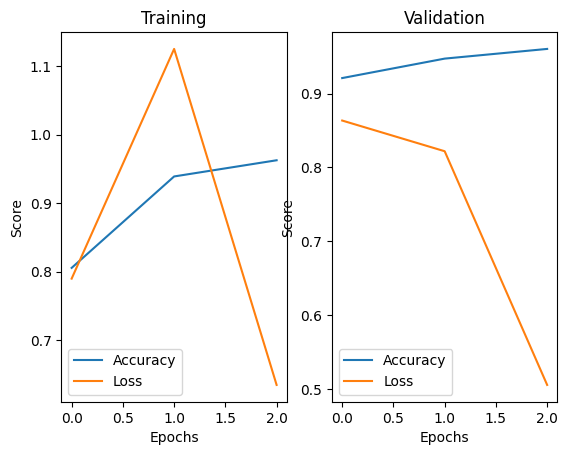

In [23]:
# Visualize the performance throughout epochs
training_acc = history.history['accuracy']
training_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(training_acc, label='Accuracy')
ax1.plot(training_loss, label='Loss')
ax1.set_title('Training')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Score')
ax1.legend()

ax2.plot(val_acc, label='Accuracy')
ax2.plot(val_loss, label='Loss')
ax2.set_title('Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend()

plt.show()

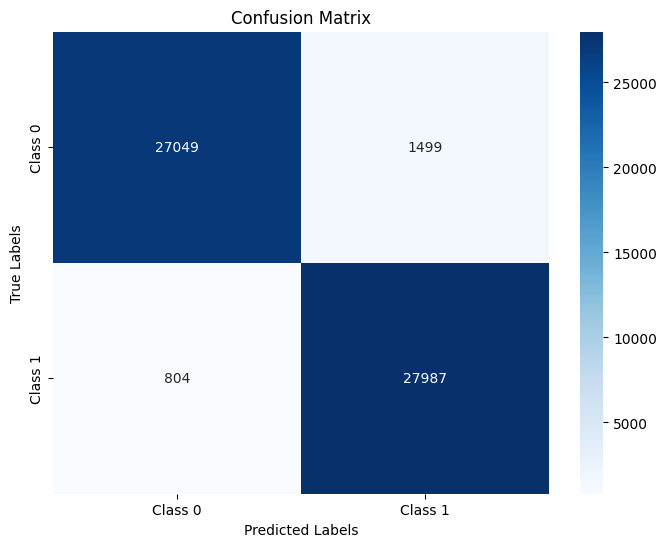

In [24]:
# Have a look at how well our model performed
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Export the model

In [25]:
model.save('../backend/artifacts/tcc_LSTM.h5')

In [26]:
import pickle

with open('../backend/artifacts/tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)